In [2]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## make any changes required to files from older version of expt and save as new file

In [3]:
# for subj in ['tomas', 'Zelin', 'renee', 'robert', 'daria']:
#     # read in csv, change col name from target to target_pos, write it back
#     df = pd.read_csv(glob.glob(f'../results/*asymmetry*{subj}*csv')[0])
#     df.rename(columns={'target': 'target_pos'}, inplace=True)
#     df.rename(columns={'context': 'valence'}, inplace=True)
#     df.rename(columns={'divider': 'div'}, inplace=True)
#     df.rename(columns={'disp_divider': 'disp_div'}, inplace=True)

#     # if trials.slider_resp.keys == None or trials.submit_resp.keys == None, then trials.correct = 0 and trials.outcome = 0
#     df.loc[df['slider_resp.keys'].isna() | df['trials.submit_resp.keys'].isna(), ['correct', 'outcome']] = 0

#     df.to_csv(f'../results/arch/formatted/{subj}.csv', index=False)

## add new subj data to combined_results

In [ ]:
# df_new_subj = pd.read_csv(glob.glob('../results/*arnav*.csv')[0])[:-3]

# # add new subj to combined_results df
# df_combined = pd.read_csv('../results/formatted/combined_results.csv')
# df_combined = pd.concat([df_combined, df_new_subj], ignore_index=True)
# df_combined.to_csv('../results/formatted/combined_results.csv', index=False)

## load df and check

In [12]:
subjs = ['tomas', 'Zelin', 'renee', 'robert', 'daria', 'salma']
subjs_anon = ['a_v2', 'b_v2', 'c_v2', 'd', 'e', 'f']

df = pd.read_csv('../results/formatted/combined_results.csv')

## filtering df

In [13]:
# 1.
print(df['correct'].value_counts(normalize=False))
print(df['outcome'].value_counts(normalize=False))
print(df['outcome'].value_counts(normalize=False))


# 2.
for col in ['positions']:
    if type(df[col][0]) == str:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x)) # convert str to list

# 3. # MAE = dist between target & last position
df['MAE_unnormed'] = abs(df['target_pos'] - df['positions'].apply(lambda x: x[-1]))
df['MAE_normed'] = np.where(
    ((df['div'] == -0.2) & (df['valence'] == 'pen')) | ((df['div'] == 0.2) & (df['valence'] == 'rew')),
    df['MAE_unnormed']*2, 
    df['MAE_unnormed']
)
# 4.
df['dist'] = df['positions'].apply(lambda x: abs(x[-1] - x[0]))
df['avg_speed'] = df['dist'] / df['trials.submit_resp.rt']

# 5.
df['choice'] = df['outcome'].apply(lambda x: 1 if abs(x) == 2 else 0 if abs(x) == 1 else 0)
# df = df[df['choice'] != 0]

# 6.
# filtering out easy trials
df_hard = df[df['target_pos'] - df['disp_div'] <= .1].copy()
print(f'% trials with |target-divider| <= .1: {len(df_hard)/len(df)}')

correct
 1    1471
-1     283
 0      46
Name: count, dtype: int64
outcome
 2    743
 1    728
-2    170
-1    138
 0     21
Name: count, dtype: int64
outcome
 2    743
 1    728
-2    170
-1    138
 0     21
Name: count, dtype: int64
% trials with |target-divider| <= .1: 0.59


## 1. analyses by valence and compression

binary_correct
1    827
0    235
Name: count, dtype: int64


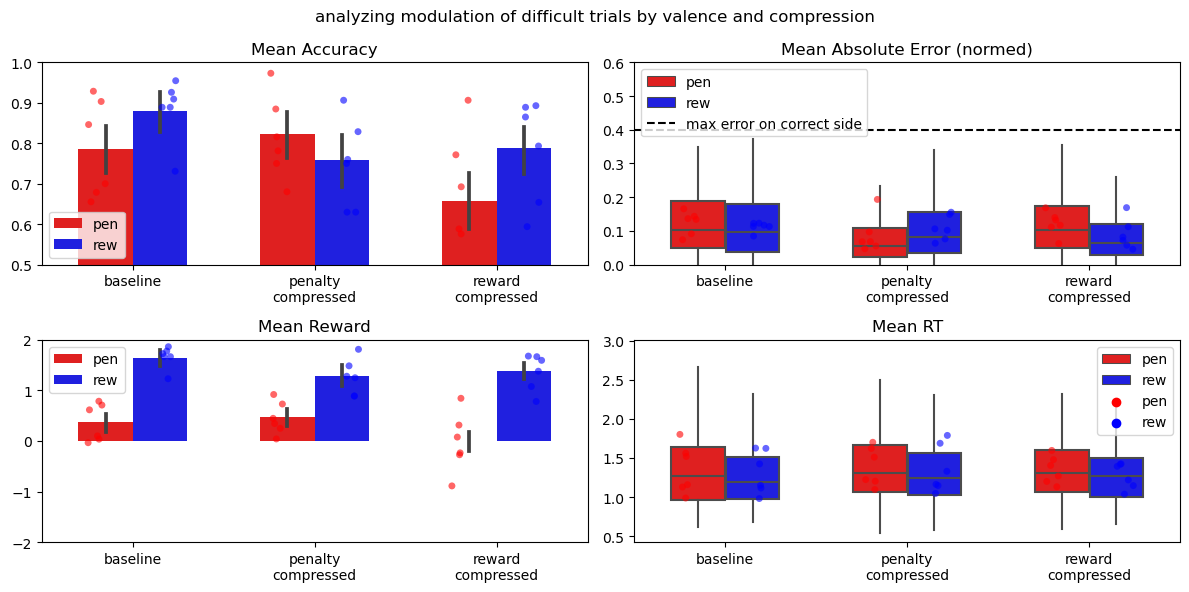

In [14]:
df_plot = df.copy()
df_plot = df_hard.copy()

df_plot['binary_correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['binary_correct'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('analyzing modulation of difficult trials by valence and compression')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# DOUBLE CHECK ALL THESE PLOTS
# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='compression', y='binary_correct', hue='valence',
            width=0.6, palette = palette, hue_order=hue_order, ax=ax)

group_df = df_plot.groupby(['subj', 'compression', 'valence'])['binary_correct'].mean().reset_index()
sns.stripplot(data=group_df, x='compression', y='binary_correct', hue='valence', 
              dodge=True, palette = palette, hue_order=hue_order, alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])


# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='compression', y='MAE_normed', hue='valence', hue_order=hue_order,
            showcaps=False, fliersize=0, width=0.6, palette = palette, ax=ax)

group_df = df_plot.groupby(['subj', 'compression', 'valence'])['MAE_normed'].mean().reset_index()
sns.stripplot(data=group_df, x='compression', y='MAE_normed', hue='valence', 
              dodge=True, palette = palette, hue_order=hue_order, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
ax.set_title('Mean Absolute Error (normed)')
# SOMETHING IS OFF HERE WITH THE LOGIC; SHOULDNT NORMALIZING ON THE EXPANDED SIDE BE DEPENDENT ON SAMPLING POSITION?
# AM I BEING TOO CONSRVATIVE WITH THE NORMALIZATION = .4?
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])


# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='compression', y='outcome', hue='valence',
            width=0.6, palette = palette, hue_order=hue_order, ax=ax)

group_df = df_plot.groupby(['subj', 'compression', 'valence'])['outcome'].mean().reset_index()
sns.stripplot(data=group_df, x='compression', y='outcome', hue='valence', hue_order=hue_order, 
              dodge=True, palette = palette, alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])


# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='compression', y='trials.submit_resp.rt', hue='valence', hue_order=hue_order,
            showcaps=False, fliersize=0, width=0.6, palette = palette, ax=ax)

group_df = df_plot.groupby(['subj', 'compression', 'valence'])['trials.submit_resp.rt'].mean().reset_index()
sns.stripplot(data=group_df, x='compression', y='trials.submit_resp.rt', hue='valence', hue_order=hue_order, 
              dodge=True, palette = palette, alpha=0.6, jitter=True, legend=True, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()
ax.set_xticklabels(['baseline', 'penalty\ncompressed', 'reward\ncompressed'])


plt.tight_layout()
plt.show()

## 2. analyses by perceptual space

percept_space
-1    411
 2    389
 1    383
-2    377
Name: count, dtype: int64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


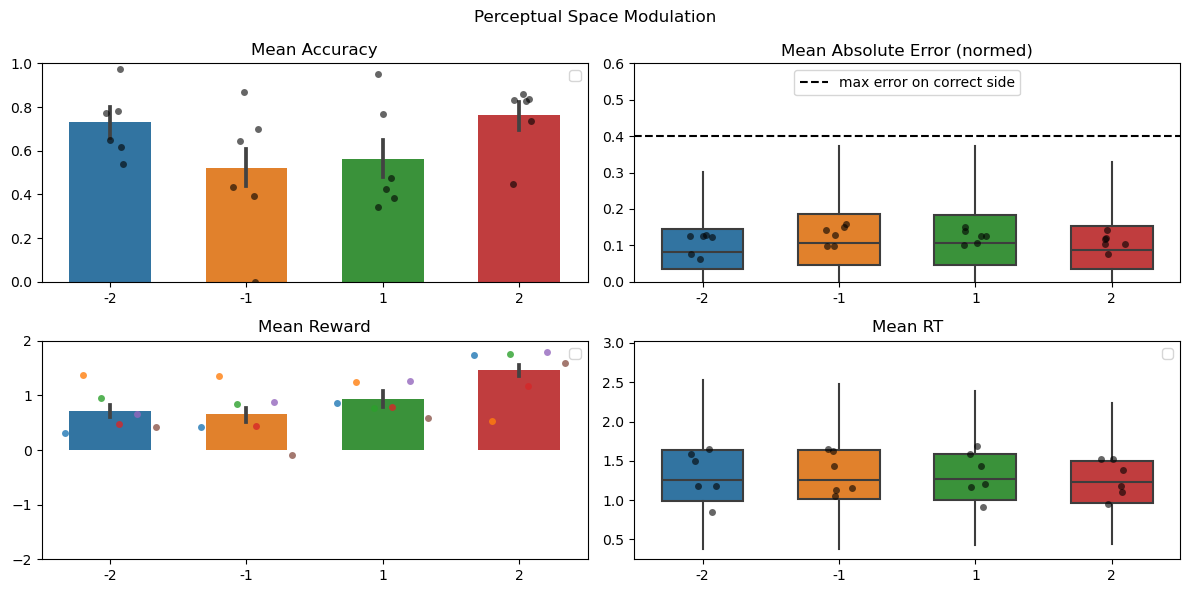

In [15]:
df_plot = df.copy()
# df_plot = df[df['subj'] == 'salma'] # just to check equal sampling in fixed version

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
values = [-2, -1, 1, 2]
df_plot['percept_space'] = np.select(conditions, values)

# probably need to flip perceptual axis for salma and some other pilots
df_plot = df_plot[df_plot['subj'] != 'salma']
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('Perceptual Space Modulation')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['correct'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='correct', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')
ax.legend()
ax.set_xticklabels(['-2', '-1', '1', '2'])

# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['MAE_normed'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
ax.set_title('Mean Absolute Error (normed)')
ax.legend()
ax.set_xticklabels(['-2', '-1', '1', '2'])

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, ax=ax)

palette = dict(zip(group_df['subj'].unique(), sns.color_palette("tab10", n_colors=len(group_df['subj'].unique()))))
group_df = df_plot.groupby(['subj', 'percept_space'])['outcome'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='outcome', hue='subj', dodge=True, alpha=0.8, jitter=True, legend=False, ax=ax)
# # draw lines between the same subjects across percept_space categories
# for subj, subj_data in group_df.groupby('subj'):
#     ax.plot(subj_data['percept_space'], subj_data['outcome'], color=palette[subj], alpha=0.6, linewidth=1)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')
ax.legend()
ax.set_xticklabels(['-2', '-1', '1', '2'])

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax)

group_df = df_plot.groupby(['subj', 'percept_space'])['trials.submit_resp.rt'].mean().reset_index()
sns.stripplot(data=group_df, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()
ax.set_xticklabels(['-2', '-1', '1', '2'])

plt.tight_layout()
plt.show()



## psychometric curves

In [78]:
from scipy.optimize import curve_fit

# Define sigmoid function
def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Convert choice to numeric (1 for risky, 0 for safe)
df_choice['choice_numeric'] = df_choice['choice'].map({'risky': 1, 'safe': 0})

# Initialize plot
plt.figure(figsize=(8, 6))

# Get unique subjects
subjects = df_choice['subj'].unique()

# Define color palette for subjects
palette = sns.color_palette("husl", len(subjects))

# Loop through each subject
for i, subj in enumerate(subjects):
    # Compute mean risky choice probability at each stim_pos for the subject
    grouped = df_choice[df_choice['subj'] == subj].groupby('stim_pos')['choice'].mean().reset_index()

    # Fit sigmoid function
    popt, _ = curve_fit(sigmoid, grouped['stim_pos'], grouped['choice'])
    
    # Generate smooth x values for curve
    x_vals = np.linspace(grouped['stim_pos'].min(), grouped['stim_pos'].max(), 100)
    y_vals = sigmoid(x_vals, *popt)

    # Plot fitted sigmoid curve
    plt.plot(x_vals, y_vals, color=palette[i], linestyle='-', label=f'Subj {subj}')

    # Scatter plot for observed probabilities
    sns.scatterplot(data=grouped, x='stim_pos', y='choice', color=palette[i], edgecolor='black')

# Labels and legend
plt.xlabel('Stimulus Position')
plt.ylabel('P(Risky Choice)')
plt.title('Psychometric Curves by Subject')
plt.legend()
plt.show()


NameError: name 'df_choice' is not defined